# COVID19 Data Visualization and Mathematically Determining Patterns in Time Series

In [ ]:
%%capture
!pip install cydets

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
print('modules are imported')
import datetime as dt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

modules are imported


## Data Preparation

In [ ]:
data_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
data = pd.read_csv(data_url)
data['Date'] = pd.to_datetime(data['Date'])
data = data[(data.Country == 'US') & (data.Confirmed > 0)]
data = data[['Date', 'Confirmed', 'Deaths']]
data['New_cases'] = data['Confirmed'].diff()
data['New_deaths'] = data['Deaths'].diff()
#remove the first row because it's NaN for new columns
data = data.reset_index(drop=True).drop(0)

In [ ]:
data.head()

,Date,Confirmed,Deaths,New_cases,New_deaths
1,2020-01-23,1,0,0.0,0.0
2,2020-01-24,2,0,1.0,0.0
3,2020-01-25,2,0,0.0,0.0
4,2020-01-26,5,0,3.0,0.0
5,2020-01-27,5,0,0.0,0.0


#### Add moving Avarage to Data

In [ ]:
data['rolling_cases'] = data.New_cases.rolling(window=7).mean()
data['rolling_deaths'] = data.New_deaths.rolling(window=7).mean()


#### Split Dataset into 3 parts: Begginig of pandemic <<>> ~25% of US citizens are vaccinated <<>> ~50% of citizens are vaccinated

In [ ]:
x0 = '2021-04-01'
x1 = '2021-08-01'

In [ ]:
fig1 = px.line(data, x = 'Date', y = ['New_cases', 'rolling_cases'], title='New Cases US')
fig1.add_shape(dict(
    type='line', x0=x0, y0=0.0,
    x1=x0, y1=data['New_cases'].max()),
    line=dict(color='red', width=2))

fig1.add_shape(dict(
    type='line', x0=x1, y0=0.0,
    x1=x1, y1=data['New_cases'].max()),
    line=dict(color='red', width=2))

fig1.add_annotation(
    dict(x=x0, y=data['New_cases'].max(), text='25% is vaccinated' ))
fig1.add_annotation(
    dict(x=x1, y=data['New_cases'].max(), text='50% is vaccinated' ))

In [ ]:
data['rolling_corr'] = data['New_cases'].rolling(7).corr(data['New_deaths']) 
px.scatter(data, x = 'Date', y = ['rolling_corr'], trendline="ols", trendline_color_override = 'red')

In [ ]:
fig2 = px.line(data, x = 'Date', y = ['New_deaths', 'rolling_deaths'])

fig2.add_shape(dict(
    type='line', x0=x0, y0=0.0,
    x1=x0, y1=data['New_deaths'].max()),
    line=dict(color='red', width=2))

fig2.add_shape(dict(
    type='line', x0=x1, y0=0.0,
    x1=x1, y1=data['New_deaths'].max()),
    line=dict(color='red', width=2))

fig2.add_annotation(
    dict(x=x0, y=data['New_deaths'].max(), text='25% is vaccinated' ))
fig2.add_annotation(
    dict(x=x1, y=data['New_deaths'].max(), text='50% is vaccinated' ))

**Summimng Up:** After vaccinating ~25% of US citizens, infection rate and death rate both goes down. After 
vaccination of ~50% citizens infection rate is going up sharply, beacause lockdowns and self-isolations were done. Death rate is going up, but not growing up as fast as infection rate. So vaccination impacts to death rate

### **In the begginning of pandemic the situation wasn't good: there was a high Death Rate, that's why the correlation in the begginning of the graph is lower that in the end**

## Reseach how Vaccination Impacts Covid19 cases and deaths


In [ ]:
data.set_index('Date', inplace=True)
before_vac = data[: '2021-04-01']
half_vac = data['2021-04-02':'2021-08-01']
rest = data['2021-08-02':]

Text(0.5, 1.0, 'Death Rateafter Half Americans got Vaccinated')

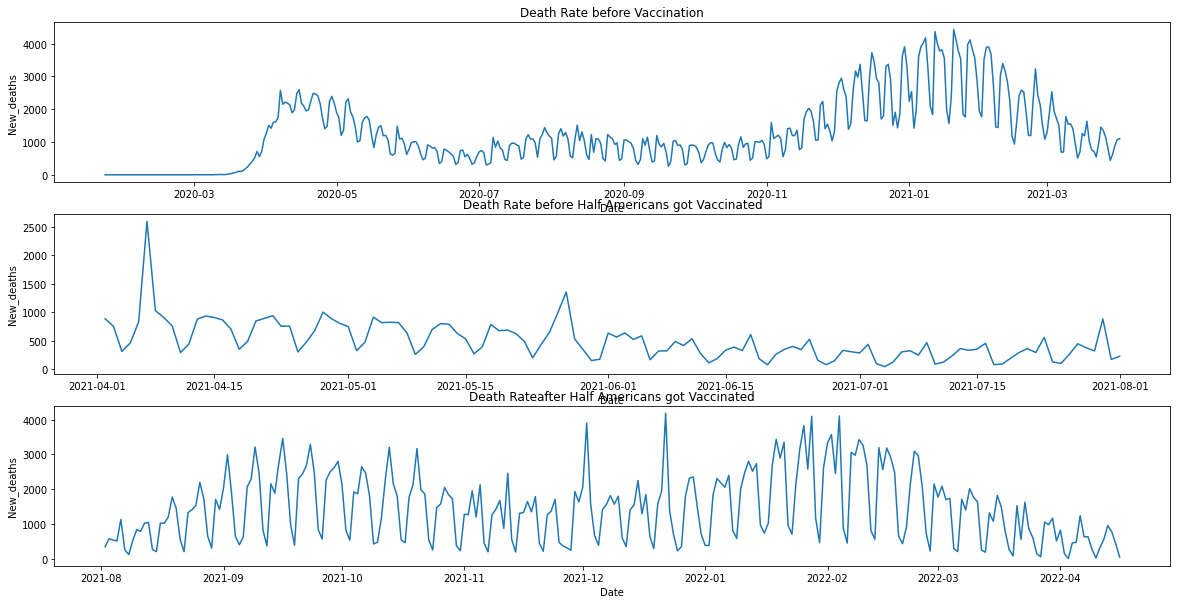

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
sns.lineplot(ax=axes[0], data=before_vac, x = 'Date', y = 'New_deaths')
axes[0].set_title('Death Rate before Vaccination')

sns.lineplot(data=half_vac, ax=axes[1], x = 'Date', y = 'New_deaths')
axes[1].set_title('Death Rate before Half Americans got Vaccinated')

sns.lineplot(data=rest, ax=axes[2], x = 'Date', y = 'New_deaths')
axes[2].set_title('Death Rateafter Half Americans got Vaccinated')

Text(0.5, 1.0, 'Confarmation Rateafter Half Americans got Vaccinated')

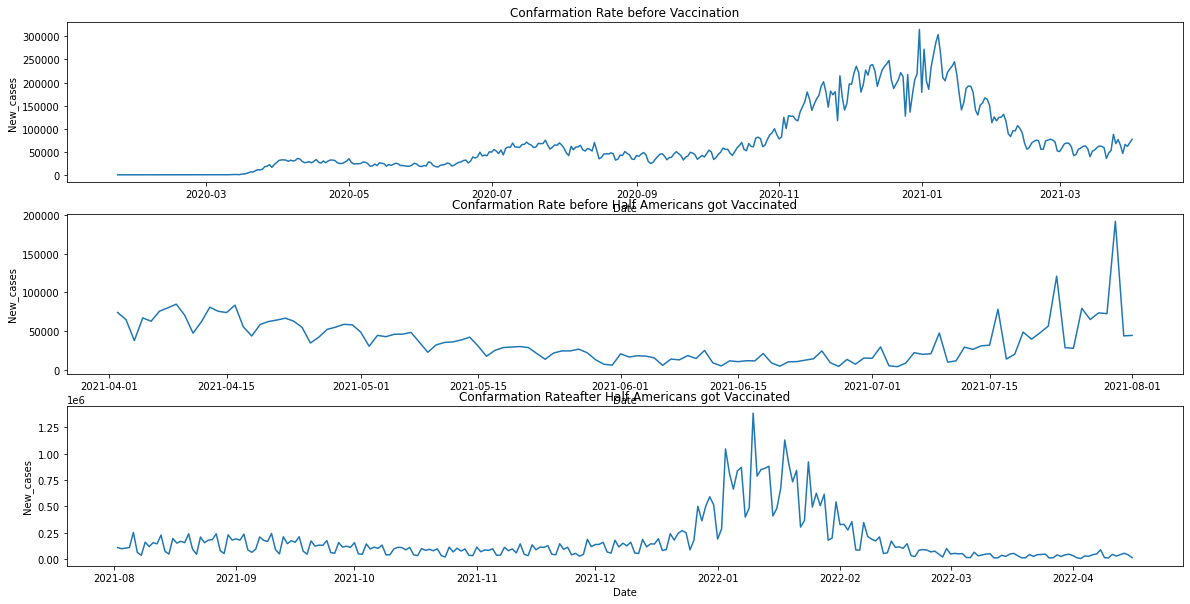

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
sns.lineplot(ax=axes[0], data=before_vac, x = 'Date', y = 'New_cases')
axes[0].set_title('Confarmation Rate before Vaccination')

sns.lineplot(data=half_vac, ax=axes[1], x = 'Date', y = 'New_cases')
axes[1].set_title('Confarmation Rate before Half Americans got Vaccinated')

sns.lineplot(data=rest, ax=axes[2], x = 'Date', y = 'New_cases')
axes[2].set_title('Confarmation Rateafter Half Americans got Vaccinated')

## Determining patterns in Time Series 
These are three common features in every time series data:
- **Seasons:** The regular ups and downs in your data, like in the figure above.
- **Trends:** When you find that data is general going upward or downword. In the figure above, there is an upward trend.
- **Cycles:** Where there are ups and downs in the data that do not seem to repeat regularly.

Can be observed the above three features by plotting the data, and checking it visually. \
Using Mathematical methods to identify these patterns in an **unobvious case**

### Check on Trend
- All cases have trend, exept Death Rate in the middle
- Using Augmented Dickey–Fuller test
- Using KPSS Test


In [ ]:
# Fuller Test 
# H0: Non-stationary
result = adfuller(x=half_vac['New_deaths'], autolag='AIC')
print('p-value is {:.4f}'.format(result[1]))
#KPSS Test
#H0: Stationary
result_kpss = kpss(x=half_vac['New_deaths'], regression='c')
print('p-value is {:.4f}'.format(result_kpss[1]))

p-value is 0.1022
p-value is 0.0100


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Both tests show it's not a stationary case. So every perios in Data has a **Trend**

### Check Sesonality for Whole Dataset using Autocorrelation

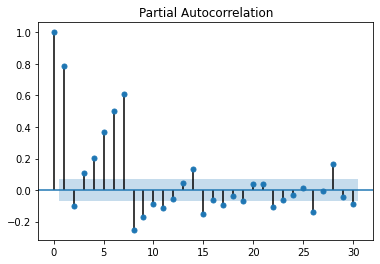

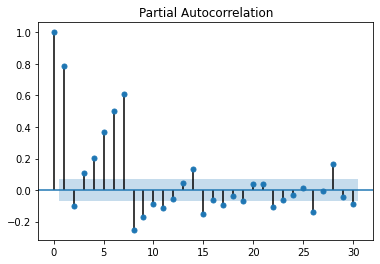

In [ ]:
plot_pacf(data['New_deaths'])

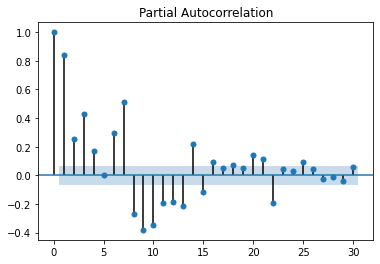

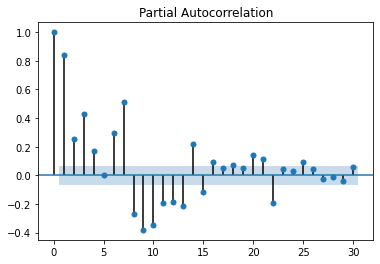

In [ ]:
plot_pacf(data['New_cases'])

**Week sesonality for whole Dataset**

### Take a closer look by checking Autocorrelation for all subsets

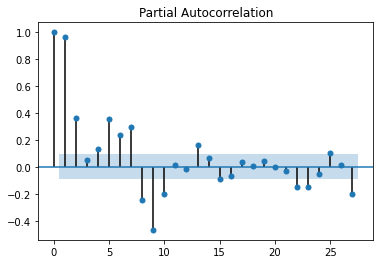

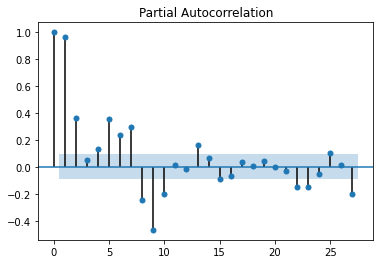

In [ ]:
plot_pacf(before_vac['New_cases'])

Strong negative correlation on 9th day

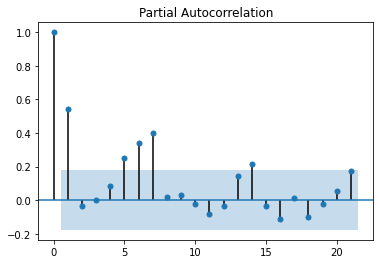

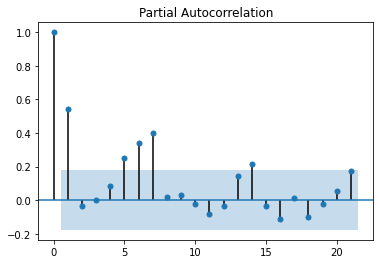

In [ ]:
plot_pacf(half_vac['New_deaths'])

**The biggest, but less than 0.5 again on 7th day**

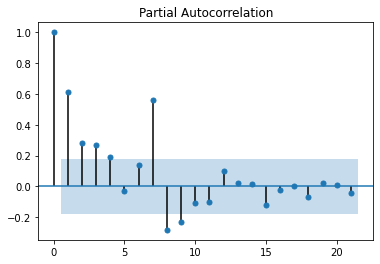

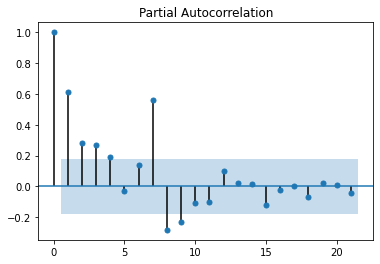

In [ ]:
plot_pacf(half_vac['New_cases'])

**Positive correlation on 7th day. This data has weekly sesonality**

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



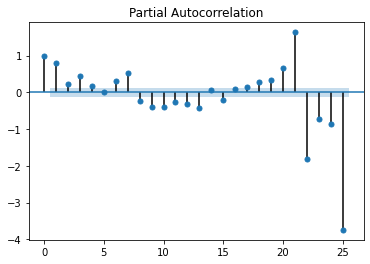

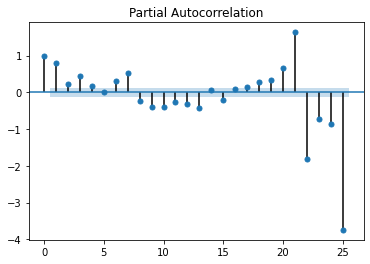

In [ ]:
plot_pacf(rest['New_cases'])

#### Look very suspicious. Check, it's a mistake

In [ ]:
%%capture
rest['lag_21'] = rest['New_cases'].shift(21)
rest['lag_22'] = rest['New_cases'].shift(22)
rest['lag_23'] = rest['New_cases'].shift(23)
rest['lag_24'] = rest['New_cases'].shift(24)
rest['lag_25'] = rest['New_cases'].shift(25)
rest['lag_7'] = rest['New_cases'].shift(7)

In [ ]:
print(f'Correlation New_cases <-> Lag 21 is {rest.lag_21.corr(rest.New_cases)}')
print(f'Correlation New_cases <-> Lag 22 is {rest.lag_22.corr(rest.New_cases)}')
print(f'Correlation New_cases <-> Lag 23 is {rest.lag_23.corr(rest.New_cases)}')
print(f'Correlation New_cases <-> Lag 24 is {rest.lag_24.corr(rest.New_cases)}')
print(f'Correlation New_cases <-> Lag 25 is {rest.lag_25.corr(rest.New_cases)}')
print(f'Correlation New_cases <-> Lag 7 is {rest.lag_7.corr(rest.New_cases)}')

Correlation New_cases <-> Lag 21 is 0.40706715252443987
Correlation New_cases <-> Lag 22 is 0.26560986555687155
Correlation New_cases <-> Lag 23 is 0.18544419208342577
Correlation New_cases <-> Lag 24 is 0.1851960487045357
Correlation New_cases <-> Lag 25 is 0.16712816485390763
Correlation New_cases <-> Lag 7 is 0.8621848131001044


**Data has 7-days seosanality**

### Cycles using CyDeTS algorithm
 Suspect Cycles in Death Rate in the First and Third parts

In [ ]:
from cydets.algorithm import detect_cycles

In [ ]:
cycles = detect_cycles(before_vac['New_deaths'])
cycles

,t_start,t_end,t_minimum,doc,duration
0,2020-02-29,2020-03-02,2020-03-01,0.000226,2 days
1,2020-03-02,2020-03-10,2020-03-03,0.000903,8 days
2,2020-03-04,2020-03-08,2020-03-05,0.000677,4 days
3,2020-03-08,2020-03-10,2020-03-09,0.000677,2 days
4,2020-03-10,2020-03-12,2020-03-11,0.000226,2 days
...,...,...,...,...,...
81,2021-03-09,2021-03-11,2021-03-10,0.002934,2 days
82,2021-03-09,2021-03-18,2021-03-14,0.253442,9 days
83,2021-03-16,2021-03-18,2021-03-17,0.014895,2 days
84,2021-03-18,2021-03-24,2021-03-22,0.205371,6 days


In [ ]:
cycles = detect_cycles(rest['New_deaths'])
cycles.iloc[:20]

,t_start,t_end,t_minimum,doc,duration
0,2021-08-02,2021-12-22,2021-08-08,0.052871,142 days
1,2021-08-03,2021-08-06,2021-08-05,0.015311,3 days
2,2021-08-10,2021-08-13,2021-08-11,0.010287,3 days
3,2021-08-13,2021-08-19,2021-08-15,0.201914,6 days
4,2021-08-16,2021-08-19,2021-08-17,0.000478,3 days
5,2021-08-19,2021-08-26,2021-08-22,0.376077,7 days
6,2021-08-26,2021-09-02,2021-08-29,0.451435,7 days
7,2021-08-30,2021-09-02,2021-08-31,0.068900,3 days
8,2021-09-02,2021-09-09,2021-09-05,0.618900,7 days
9,2021-09-09,2021-09-16,2021-09-12,0.680622,7 days


### Decompose to Trend, Season and Errors all Subsets

Whole Dataset

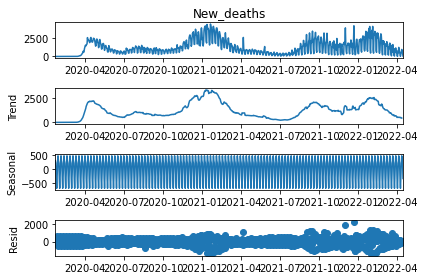

In [ ]:
res = sm.tsa.seasonal_decompose(data['New_deaths'])
resplot = res.plot()

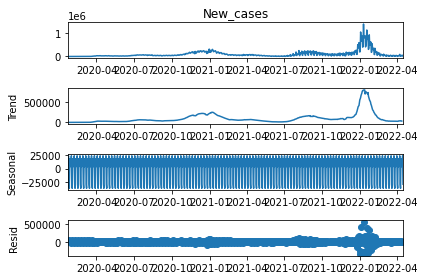

In [ ]:
res = sm.tsa.seasonal_decompose(data['New_cases'])
resplot = res.plot()

#### Decomposition by Parts

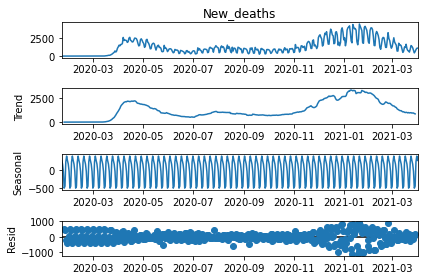

In [ ]:
res = sm.tsa.seasonal_decompose(before_vac['New_deaths'])
resplot = res.plot()

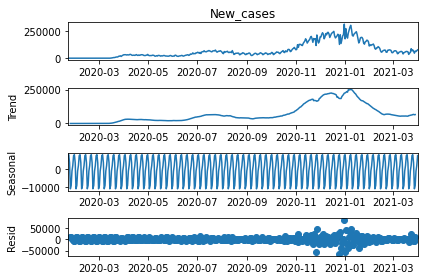

In [ ]:
res = sm.tsa.seasonal_decompose(before_vac['New_cases'])
resplot = res.plot()

Trends are almost same in the second part, but in the begginning there was a pick of deaths. Winter 2020-2021 was a hard time.

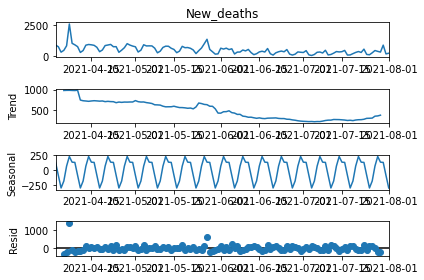

In [ ]:
res = sm.tsa.seasonal_decompose(half_vac['New_deaths'])
resplot = res.plot()

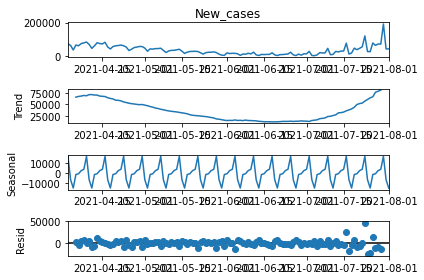

In [ ]:
res = sm.tsa.seasonal_decompose(half_vac['New_cases'])
resplot = res.plot()

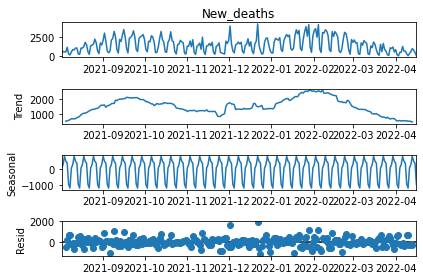

In [ ]:
res = sm.tsa.seasonal_decompose(rest['New_deaths'])
resplot = res.plot()

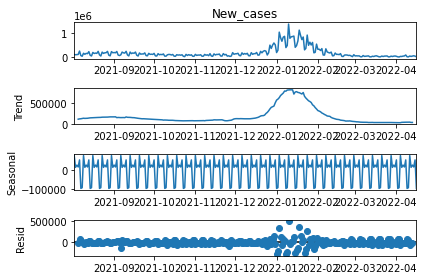

In [ ]:
res = sm.tsa.seasonal_decompose(rest['New_cases'])
resplot = res.plot()

In the 3rd part of dataset there is almost no correlation between New Cases Rate and Death Rate

### Fitted Model STL

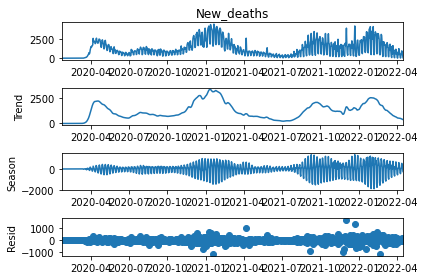

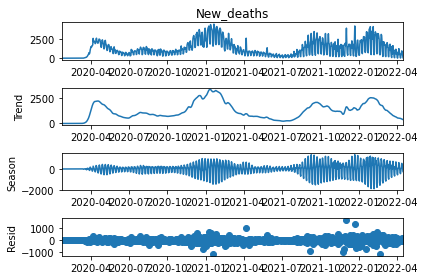

In [ ]:
stl = STL(data['New_deaths'], period=7).fit()
stl.plot()

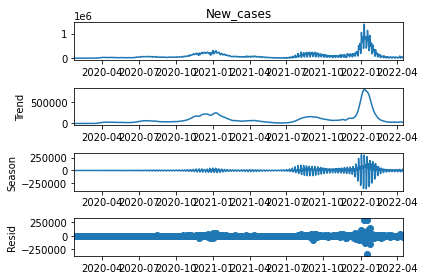

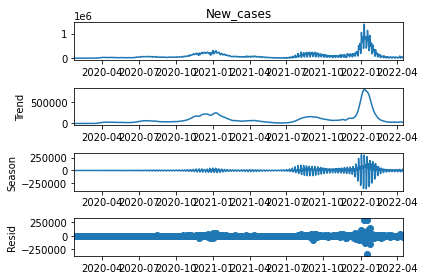

In [ ]:
stl = STL(data['New_cases'], period=7).fit()
stl.plot()

### Fitted Models give the best result, Errors much less compare to non-fitted decompositional models